## Model Re-Training @ Scale - Middle Loop 

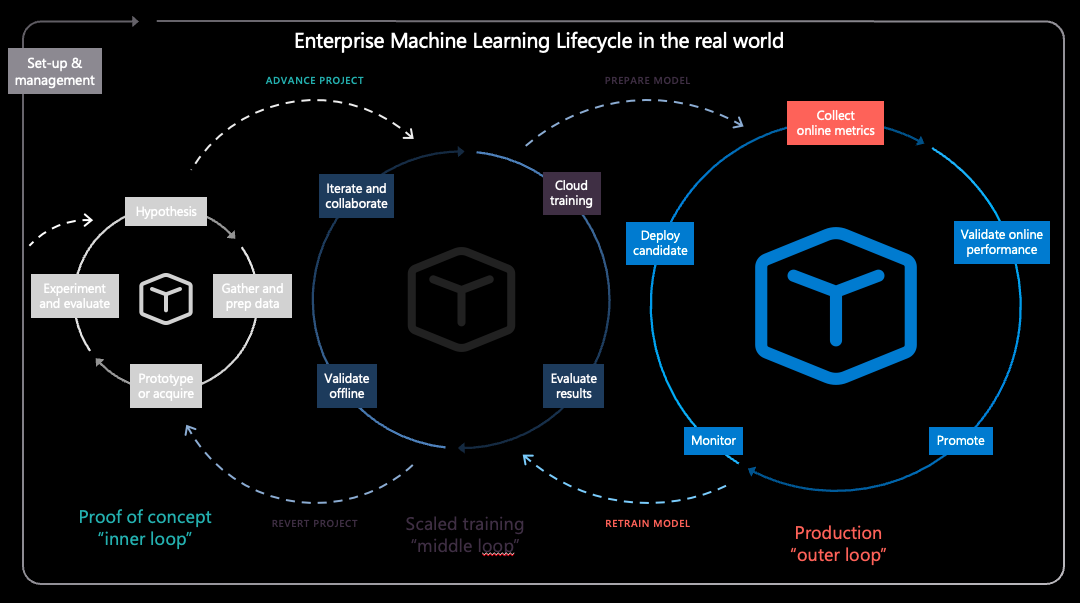

## Use a command job to train a model in Azure Machine Learning

To train a model, you need to submit a *job*. The type of job you'll submit in this tutorial is a *command job*. Azure Machine Learning offers several different types of jobs to train models. Users can select their method of training based on complexity of the model, data size, and training speed requirements.  In this tutorial, you'll learn how to submit a *command job* to run a *training script*. 

A command job is a function that allows you to submit a custom training script to train your model. This can also be defined as a custom training job. A command job in Azure Machine Learning is a type of job that runs a script or command in a specified environment. You can use command jobs to train models, process data, or any other custom code you want to execute in the cloud. 

In this tutorial, we'll focus on using a Azure Command Line Interface (CLI) to configure and submit a training job that we'll use to train a model. For any custom training job, the below items are required:

* compute resource (usually a compute cluster, which we recommend for scalability)
* job-specific environment dependencies configuration
* data
* command job 
* training script


In this tutorial we'll provide all these items for our example: creating a classifier to predict customers who have a high likelihood of defaulting on credit card payments.


## Load local environment

For the purposes of this tutorial, environment variables used during the exercise are stored in a .env file.  Please create or modify your local .env file prior to the next steps.

(Optional) If not already installed, install environment management package

In [1]:
!conda install python-dotenv

SyntaxError: invalid syntax (3315751128.py, line 3)

### Set environment variable values

- Step 1: Copy the provided .env.sample and rename it to .env
- Step 2: Set the variables in the newly created .env file to your account-specific values
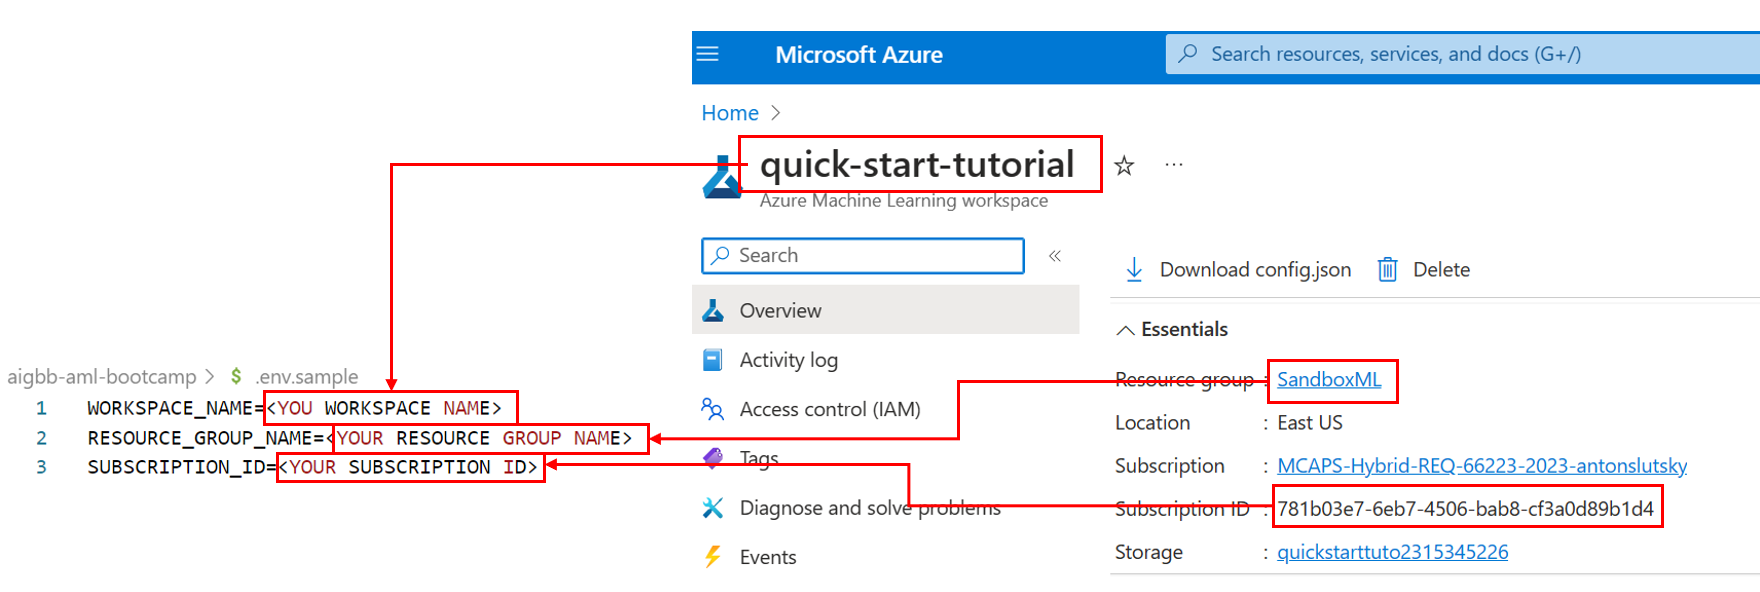
- Step 3: Proceed to the next step 

Load local environment from the .env file

In [11]:
%reload_ext dotenv
%dotenv

##### Configure Azure ML session

It is now necessary to configure local Azure ML session to point to the appropriate workspace and resource group.  The following code configures local CLI environment for subsequent use.

In [2]:
import platform 
current_platform = platform.system()
if "Windows" == current_platform:
    !az configure --defaults workspace=%WORKSPACE_NAME% group=%RESOURCE_GROUP_NAME%
else:
    !az configure --defaults workspace=$WORKSPACE_NAME group=$RESOURCE_GROUP_NAME

## Configure a training job using the command function

You create an Azure Machine Learning *command job* to train a model for credit default prediction. The command job runs a *training script* in a specified environment on a specified compute resource.  You've already created the environment and the compute cluster.  Next you'll create the training script. In our specific case, we're training our dataset to produce a classifier using the `GradientBoostingClassifier` model. 

The *training script* handles the data preparation, training and registering of the trained model. The method `train_test_split` handles splitting the dataset into test and training data. In this tutorial, you'll create a Python training script. 

Command jobs can be run from CLI, Python SDK, or studio interface. In this tutorial, you'll use the Azure Machine Learning Python SDK v2 to create and run the command job.





##### Generate a modified training script

In [14]:
%%writefile src/main_new.py
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--n_estimators", required=False, default=100, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    args = parser.parse_args()
   
    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    ###################
    #<prepare the data>
    ###################
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)
    
    credit_df = pd.read_csv(args.data, header=1, index_col=0)

    mlflow.log_metric("num_samples", credit_df.shape[0])
    mlflow.log_metric("num_features", credit_df.shape[1] - 1)

    #Split train and test datasets
    train_df, test_df = train_test_split(
        credit_df,
        test_size=args.test_train_ratio,
    )
    ####################
    #</prepare the data>
    ####################

    ##################
    #<train the model>
    ##################
    # Extracting the label column
    y_train = train_df.pop("default payment next month")

    # convert the dataframe values to array
    X_train = train_df.values

    # Extracting the label column
    y_test = test_df.pop("default payment next month")

    # convert the dataframe values to array
    X_test = test_df.values

    print(f"Training with data of shape {X_train.shape}")

    clf = GradientBoostingClassifier(
        n_estimators=args.n_estimators, learning_rate=args.learning_rate
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    ###################
    #</train the model>
    ###################

    ##########################
    #<save and register model>
    ##########################
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=clf,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################
    
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

Overwriting src/main_new.py


##### Run training script via command job, use csv dataset

The Azure ML CLI interface accepts job configuration parameters via YAML.  The following ipython magic block writes a sample YAML configuration to a local file.

In [15]:
%%writefile dependencies/cli_job_new.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: ../src
command: >-
  python main_new.py 
  --data ${{inputs.data}} 
  --test_train_ratio ${{inputs.test_train_ratio}} 
  --learning_rate ${{inputs.learning_rate}} 
  --registered_model_name ${{inputs.registered_model_name}}
inputs:
  data: 
    type: uri_file
    path: azureml:credit-card_csv:2023.10.05.154542
  test_train_ratio: 0.2
  learning_rate: 0.25
  registered_model_name: credit_default_model
environment: 
  image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
  conda_file: conda.yml
compute: azureml:cpu-cluster
display_name: sklearn-iris-example
experiment_name: sklearn-iris-example
description: Train a scikit-learn SVM on the Iris dataset.

Writing dependencies/cli_job_new.yml


## Submit the job 

It's now time to submit the job to run in Azure Machine Learning studio. This time you'll use `create_or_update`  on `ml_client`. `ml_client` is a client class that allows you to connect to your Azure subscription using Python and interact with Azure Machine Learning services. `ml_client` allows you to submit your jobs using Python.

In [16]:
!az ml job create -f dependencies\cli_job_new.yml --query name -o tsv

olive_lunch_15w4fzyrs8


Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.

Uploading src (0.01 MBs): 100%|######

## Use Parquet dataset for Model Training



Write a new job configuration YAML file to use the Parquet data

In [9]:
%%writefile dependencies/cli_job_parquet.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: ../src
command: >-
  python main.py 
  --data ${{inputs.data}} 
  --test_train_ratio ${{inputs.test_train_ratio}} 
  --learning_rate ${{inputs.learning_rate}} 
  --registered_model_name ${{inputs.registered_model_name}}
inputs:
  data: 
    type: uri_file
    path: azureml:credit-card:2023.10.04.141709_cleaned
  test_train_ratio: 0.2
  learning_rate: 0.25
  registered_model_name: credit_default_model
environment: 
  image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
  conda_file: conda.yml
compute: azureml:cpu-cluster
display_name: sklearn-iris-example
experiment_name: sklearn-iris-example
description: Train a scikit-learn SVM on the Iris dataset.

Writing dependencies/cli_job_parquet.yml


In [10]:
!az ml job create -f dependencies\cli_job.yml --query name -o tsv

silver_bee_7hsyr26tbz


Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
